# Used Car Price Prediction


## Objective

The objective of this competition is to **predict the price of used cars** based on various attributes, such as brand, model, manufacturing year, mileage, <br>
fuel type, engine specifications, and more. Participants are required to build a machine learning model that accurately estimates car prices using the <br>
provided dataset, which contains information about each vehicle's features and characteristics. The model's performance will be evaluated based on <br>
the **Root Mean Squared Error (RMSE)** between the predicted prices and the actual prices.

## Dataset

- **Brand & Model**: Identify the brand or company name along with the specific model of each vehicle.
- **Model Year**: Discover the manufacturing year of the vehicles, crucial for assessing depreciation and technology advancements.
- **Mileage**: Obtain the mileage of each vehicle, a key indicator of wear and tear and potential maintenance requirements.
- **Fuel Type**: Learn about the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.
- **Engine Type**: Understand the engine specifications, shedding light on performance and efficiency.
- **Transmission**: Determine the transmission type, whether automatic, manual, or another variant.
- **Exterior & Interior Colors**: Explore the aesthetic aspects of the vehicles, including exterior and interior color options.
- **Accident History**: Discover whether a vehicle has a prior history of accidents or damage, crucial for informed decision-making.
- **Clean Title**: Evaluate the availability of a clean title, which can impact the vehicle's resale value and legal status.
- **Price**: Access the listed prices for each vehicle, aiding in price comparison and budgeting.

## Data Exploration

### Loading fuctions & Datasets

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import warnings
import re
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import optuna

warnings.filterwarnings("ignore")

C:\Users\shudi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_missing_percentage(train_df): 
    # Calculate the percentage of missing values for each column
    missing_percentage = train_df.isna().mean() * 100

    # Display the percentage of missing values for each column
    print("\nMissing Percentage and Data Types for Each Column:")
    print("")
    print(missing_percentage)


# Function to extract horsepower
def extract_horsepower(engine):
    if pd.isna(engine):  # Check if the value is NaN
        return np.nan
    pattern = r"(\d+\.?\d*)HP"  # Regular expression to find horsepower value
    match = re.search(pattern, engine)
    if match:
        return str(match.group(1))  # Return horsepower as a float
    return np.nan

# Function to extract engine size (in Liters)
def extract_engine_size(engine):
    if pd.isna(engine):  # Check if the value is NaN
        return np.nan
    pattern = r"(\d+\.?\d*)L"  # Regular expression to find engine size (in Liters)
    match = re.search(pattern, engine)
    if match:
        return str(match.group(1))  # Return engine size as a float
    return np.nan

# Function to extract number of cylinders
def extract_cylinders(engine):
    if pd.isna(engine):  # Check if the value is NaN
        return np.nan

    # Regular expression to find cylinder count (like "8 Cylinder")
    cylinder_pattern = r"(\d+)\sCylinder"
    match = re.search(cylinder_pattern, engine)
    
    # If the direct extraction succeeds, return the matched number
    if match:
        return match.group(1)  # Return cylinder count as a string
    
    # Define patterns for common engine types like "I4", "V6", "V8", etc.
    pattern_v = ["I4", "V6", "V8", "V10", "V12"]
    pattern_vex = r"(?:^|\s+)(" + "|".join(pattern_v) + r")(?:\s+|$)"
    
    # Try to extract from the shorthand notation like "V6" or "I4"
    match_vex = re.search(pattern_vex, engine)
    if match_vex:
        # Return the numeric part of the shorthand (like '4' from 'I4')
        return re.search(r"\d+", match_vex.group(1)).group(0)
    
    # If no match, return NaN
    return np.nan

# Function to extract fuel type
def extract_fuel_type(engine):
    if pd.isna(engine):  # Check if the value is NaN
        return np.nan
    pattern = r"(Gasoline|Diesel|Electric|Hybrid|Flex Fuel Capability)"  # Regular expression to find fuel type
    match = re.search(pattern, engine)
    if match:
        return match.group(1)  # Return the fuel type as a string
    return np.nan

# Define transmission patterns
transmission_patterns = [
    "A/T", "w/Dual", "M/T", "Automatic", "CVT", "Auto-Shift", "Manual", 
    "Variable", "F", "Overdrive", "Electronically", "At/Mt", "DCT", "CVT-F", "AT"
]

# Compile the regex pattern for transmission extraction
transmission_pattern_ex = r"(?:^|\s+)(" + "|".join(transmission_patterns) + r")(?:\s+|$)"

# Function to extract transmission type
def extract_transmission_type(transmission):
    if pd.isna(transmission):  # Handle NaN values
        return np.nan
    
    # Extract the transmission type using the regex pattern
    match = re.search(transmission_pattern_ex, str(transmission))
    
    if match:
        transmission_type = match.group(1)  # Get the matched transmission type
        
        # Normalize the transmission type
        transmission_type = transmission_type.replace("A/T", "AT").replace("M/T", "MT")
        
        # Map transmission type to broader categories
        transmission_type = {
            "AT": "Automatic",
            "Automatic": "Automatic",
            "MT": "Manual",
            "Manual": "Manual",
            "CVT": "CVT",
            "Auto-Shift": "Automatic",
            "DCT": "Automatic",
            "Variable": "CVT",
            "F": "Other",
            "Overdrive": "Automatic",
            "Electronically": "Automatic",
            "At/Mt": "Other",
            "CVT-F": "CVT",
        }.get(transmission_type, "Other")  # Default to "Other" if not found
        
        return transmission_type
    return np.nan

# Set a Seaborn theme (choose from darkgrid, whitegrid, dark, white, ticks)
sns.set_theme(style="whitegrid")

# Function to draw a bar chart for a categorical feature, sorted by count, with counts on top of bars
def draw_categorical_bar_chart(data, column_name):
    plt.figure(figsize=(10, 6))

    # Sort the values by count in descending order
    sorted_data = data[column_name].value_counts().index

    # Draw the countplot with sorted categories
    ax = sns.countplot(x=column_name, data=data, order=sorted_data, palette="crest")

    # Add the count labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.xticks(rotation=45)
    plt.title(f'Bar Chart for {column_name} (Sorted by Count)')
    plt.tight_layout()
    plt.show()

# Function to draw a bar chart for a categorical feature with options to limit categories and handle large numbers of bars
def draw_categorical_bar_chart(data, column_name, top_n=20):
    plt.figure(figsize=(12, 8))

    # Get value counts for the column and handle if there are too many bars
    value_counts = data[column_name].value_counts()

    if len(value_counts) > top_n:
        # Combine all categories outside of top_n into "Other"
        value_counts = value_counts.nlargest(top_n)
        value_counts['Other'] = data[column_name].value_counts()[top_n:].sum()

    # Sort the values by count in descending order
    sorted_data = value_counts.index

    # Draw the countplot with sorted categories
    ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="crest")

    # Add the count labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.xticks(rotation=45, ha='right')
    plt.title(f'Distribution for {column_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

In [3]:
# Load the dataset
train_df = pd.read_csv(r'C:\Users\shudi\OneDrive\Desktop\Projects\Kaggle Competition\used_car_price_prediction\train.csv')
test_df = pd.read_csv(r'C:\Users\shudi\OneDrive\Desktop\Projects\Kaggle Competition\used_car_price_prediction\test.csv')

# Preview the data
print("Train Data:")
train_df.head()

Train Data:


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


### What are the values we have for each columns

* Distribution for Each Columns
* Percentage of missing values in each column

In [4]:
# use Jinja2 to format output fir numerical feature distribution
train_df[['milage', 'price']].describe().round(2).style.format(precision=2).background_gradient(cmap="Blues")

,milage,price
count,188533.00,188533.00
mean,65705.30,43878.02
std,49798.16,78819.52
min,100.00,2000.00
25%,24115.00,17000.00
50%,57785.00,30825.00
75%,95400.00,49900.00
max,405000.00,2954083.00


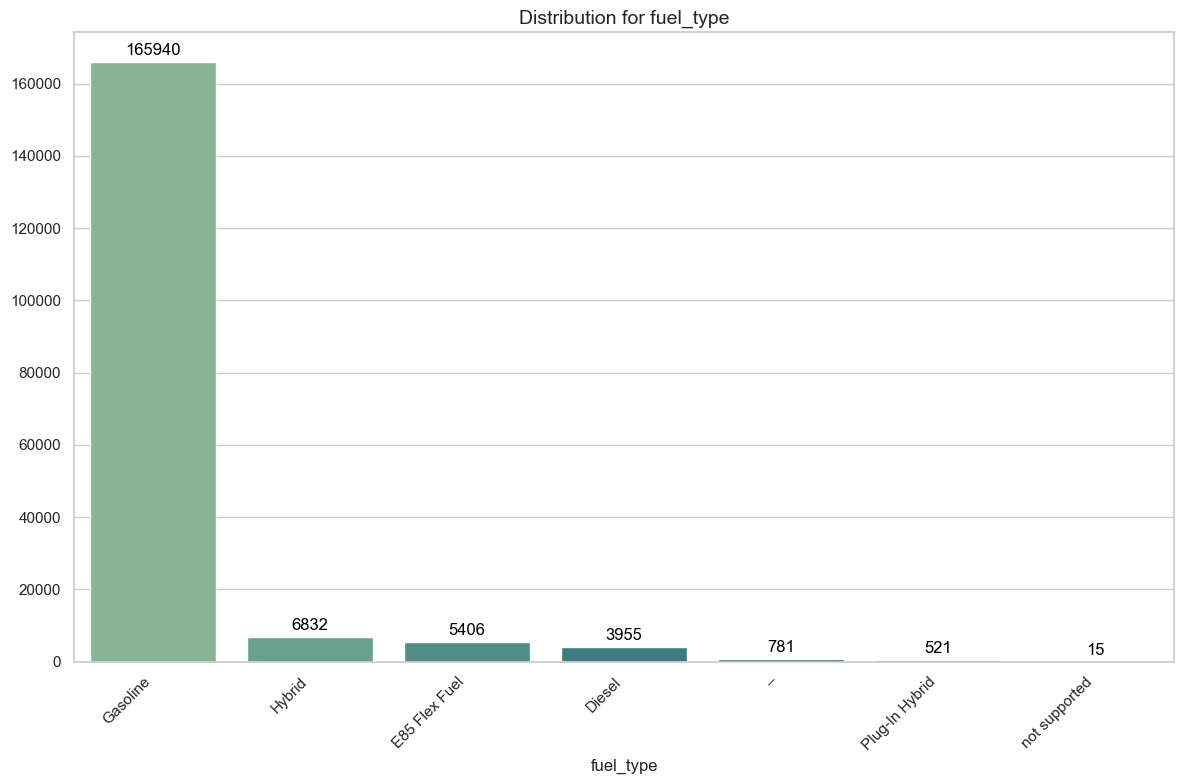

In [5]:
draw_categorical_bar_chart(train_df, 'fuel_type', top_n=20)

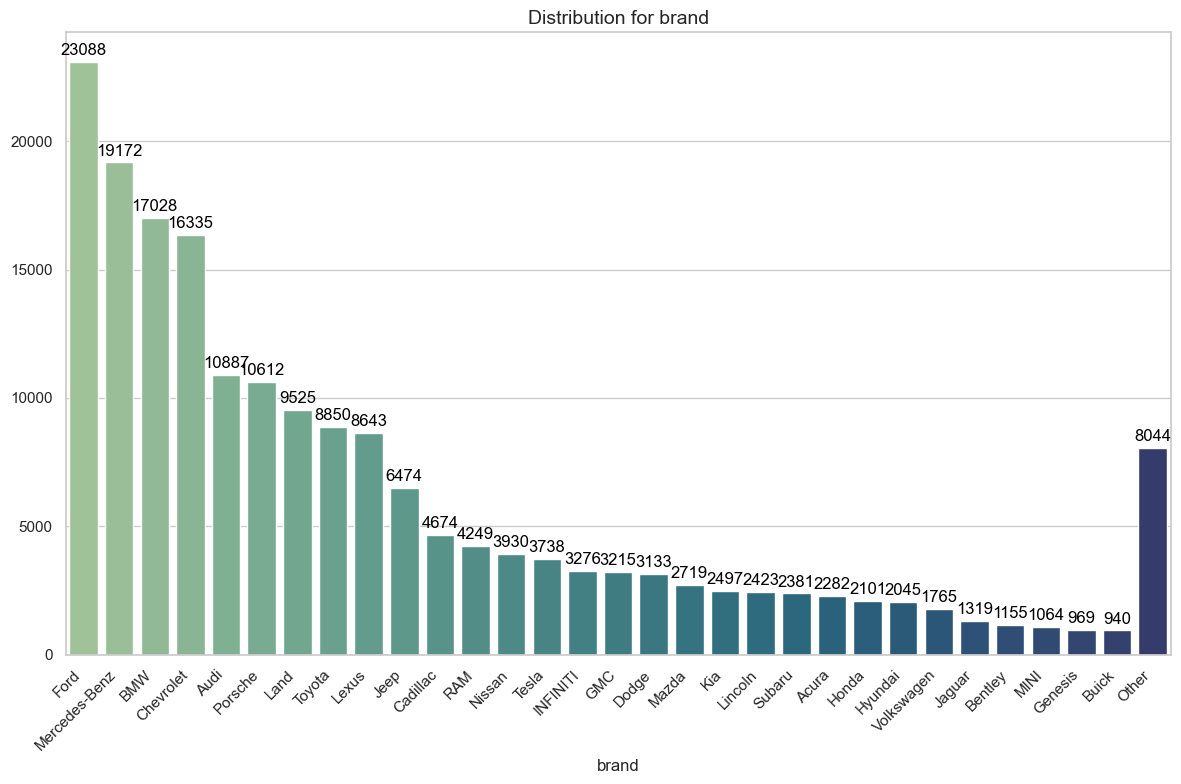

In [6]:
draw_categorical_bar_chart(train_df, 'brand', top_n=30)

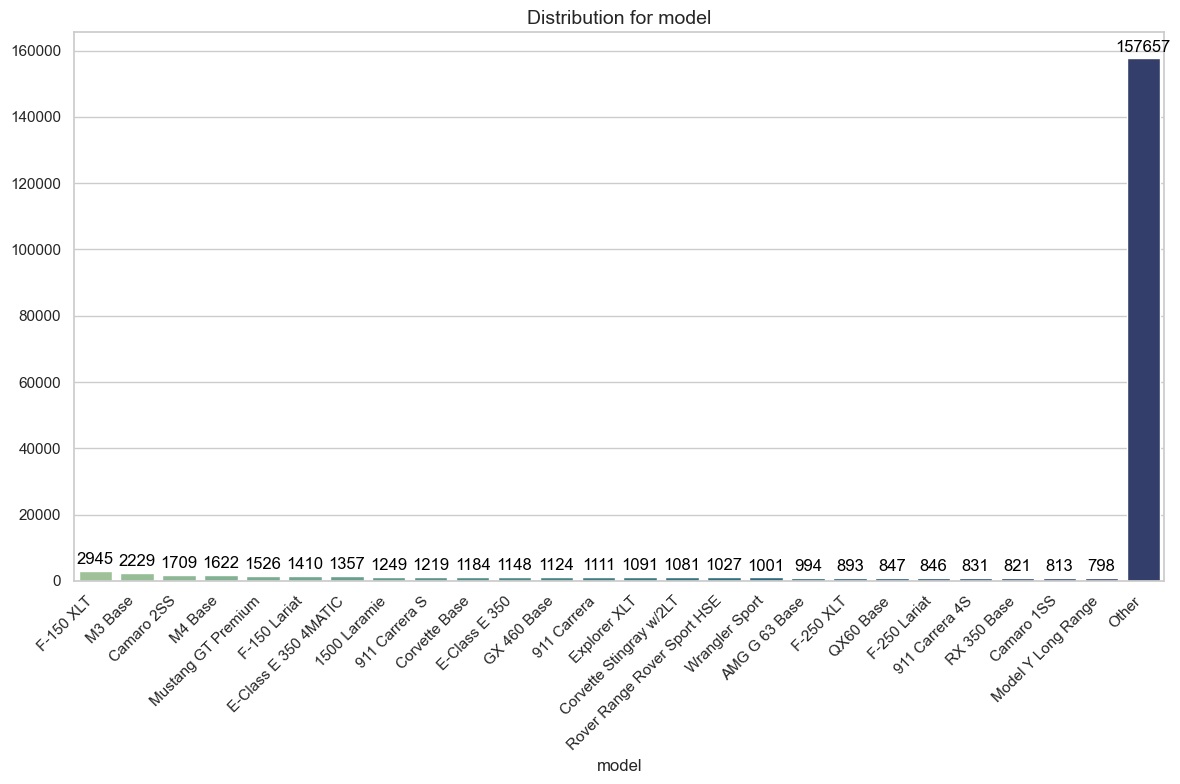

In [7]:
draw_categorical_bar_chart(train_df, 'model', top_n=25)

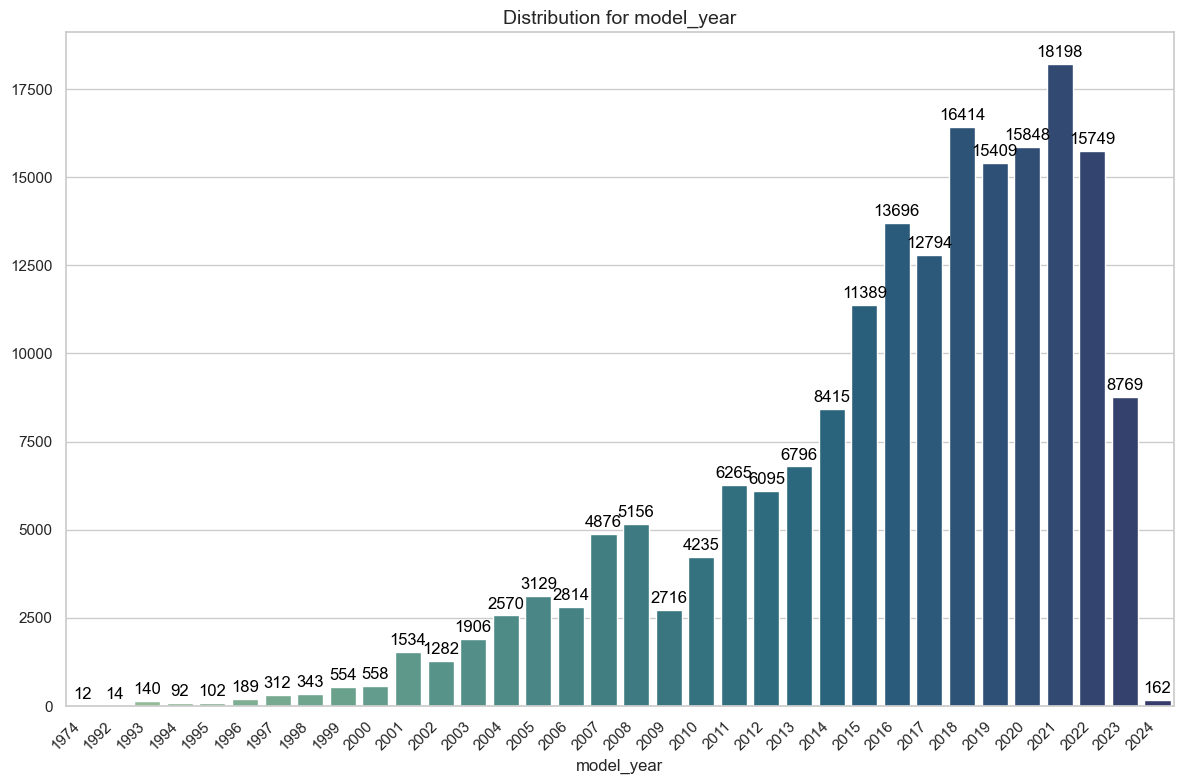

In [8]:
draw_categorical_bar_chart(train_df, 'model_year', top_n=35)

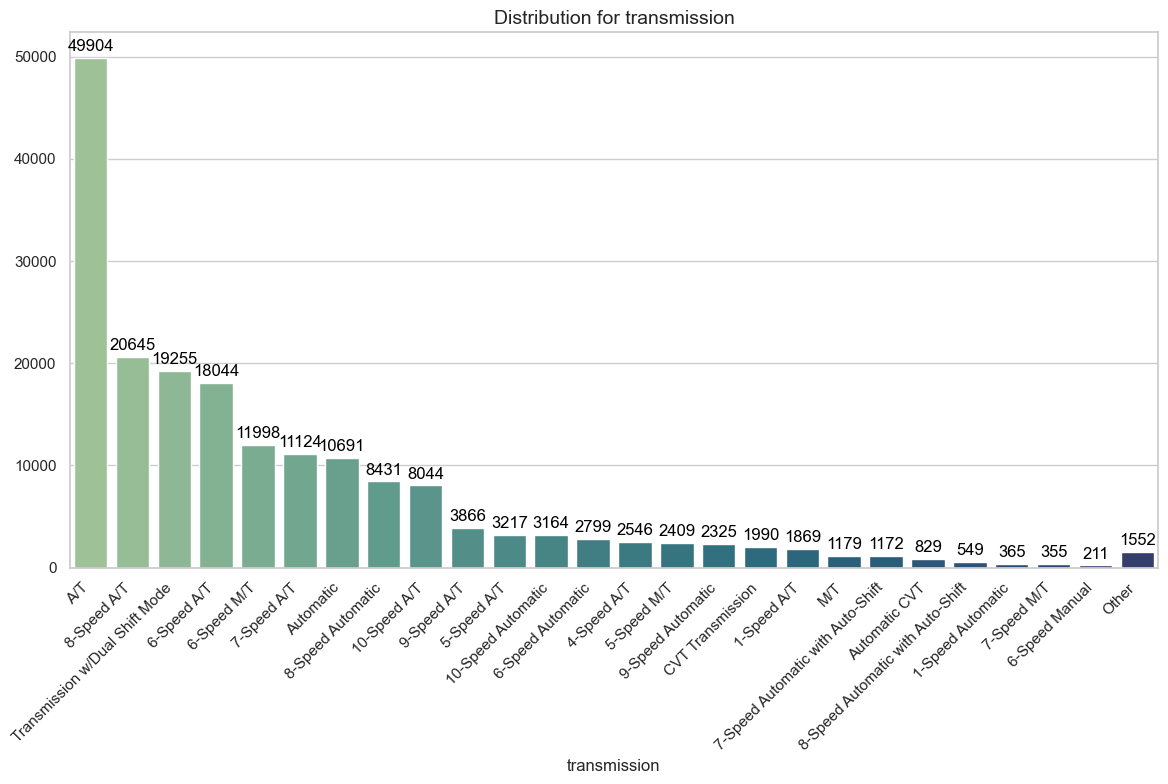

In [9]:
draw_categorical_bar_chart(train_df, 'transmission', top_n=25)

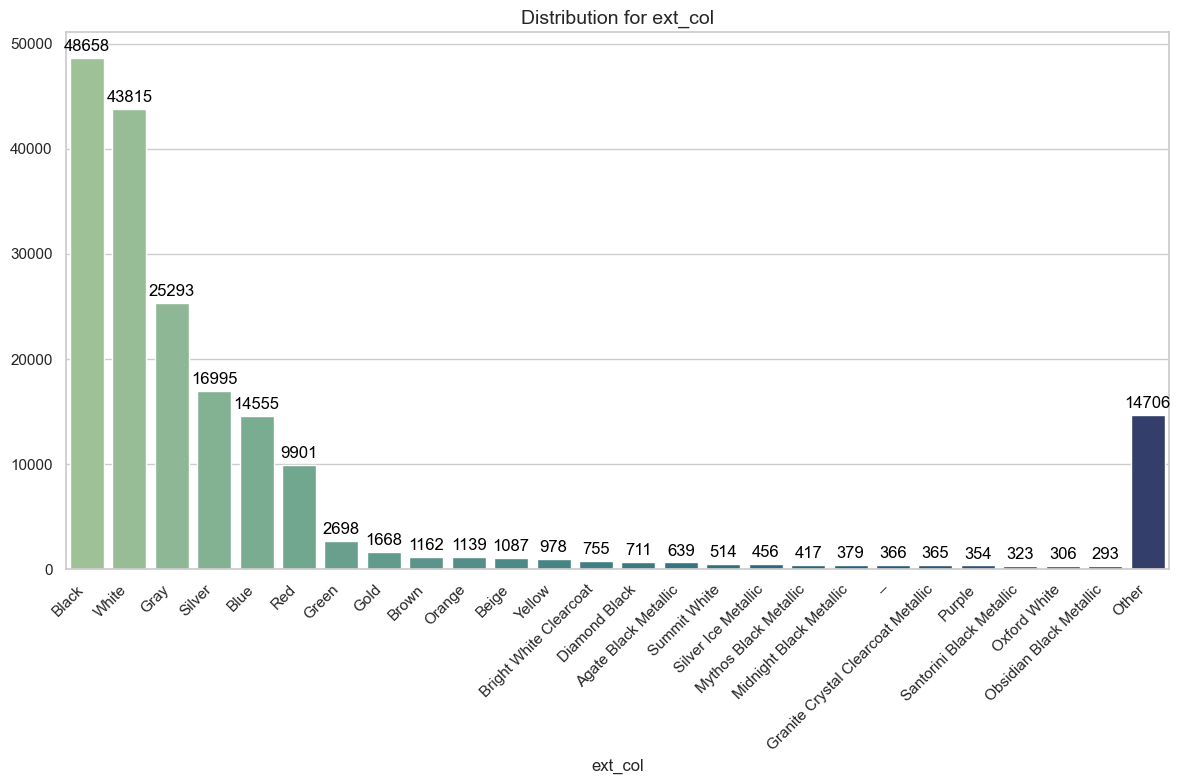

In [10]:
draw_categorical_bar_chart(train_df, 'ext_col', top_n=25)

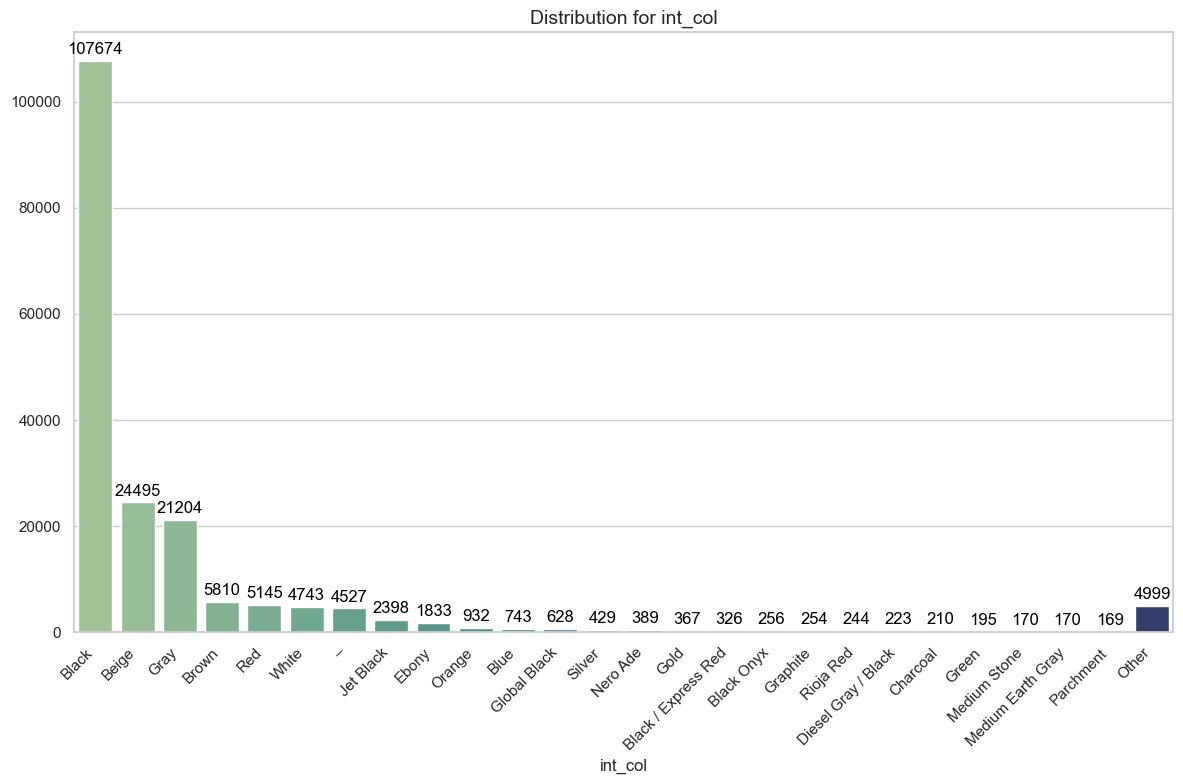

In [11]:
draw_categorical_bar_chart(train_df, 'int_col', top_n=25)

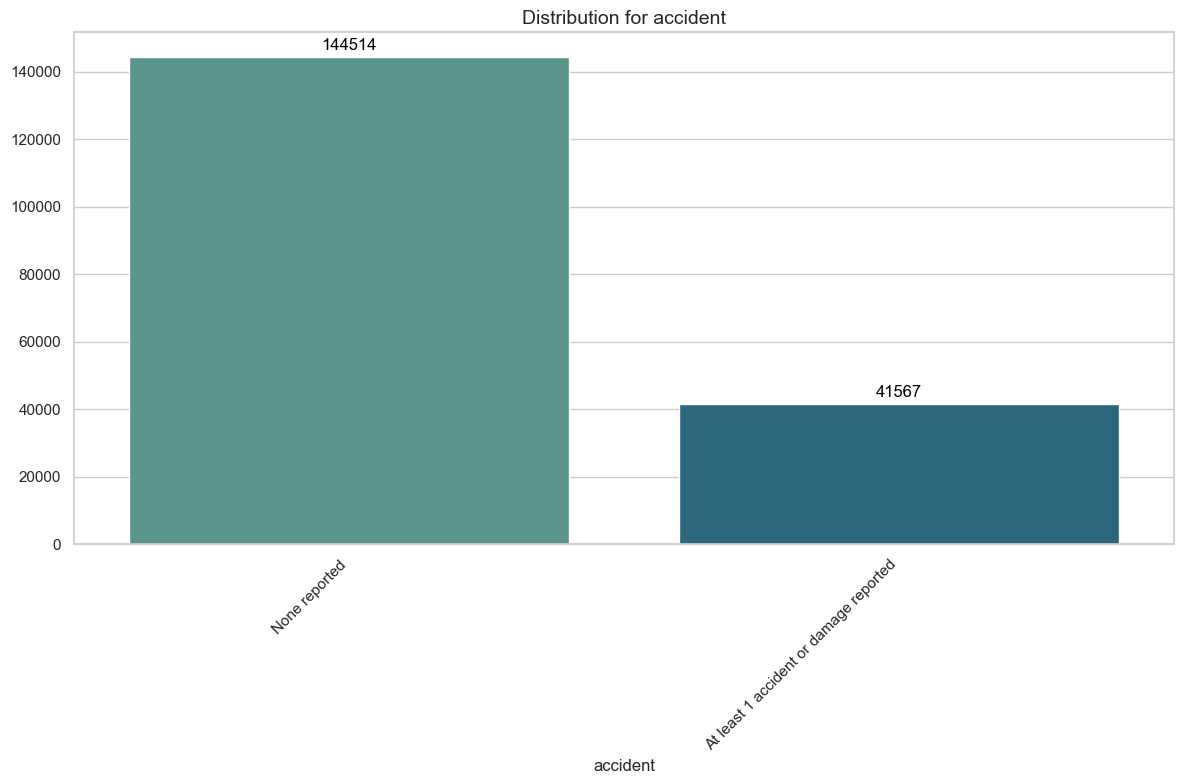

In [12]:
draw_categorical_bar_chart(train_df, 'accident', top_n=25)

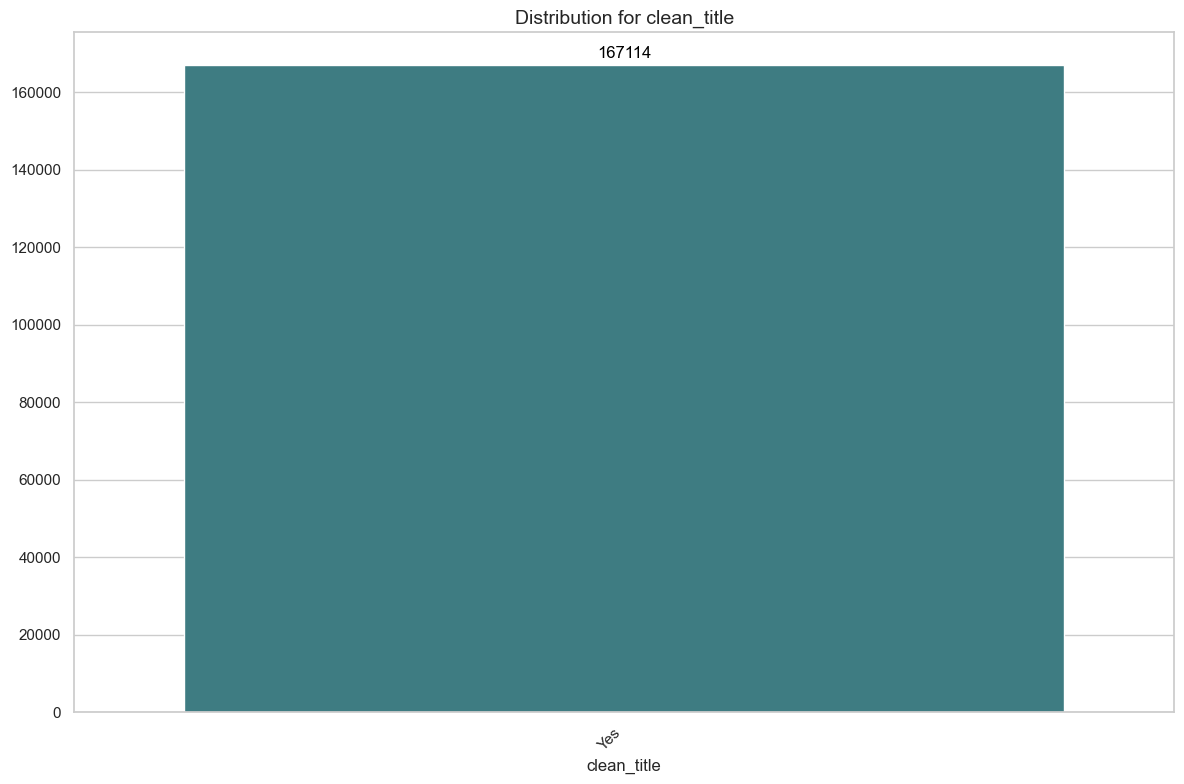

In [13]:
draw_categorical_bar_chart(train_df, 'clean_title', top_n=25)

In [14]:
calculate_missing_percentage(train_df)


Missing Percentage and Data Types for Each Column:

id               0.000000
brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64


### Preprocess

We process categorical and numerical features of train and test data combined.

For categoricals, we label all rare values as label=Rare and NAN as label=Unknown. We define a rare value as samples < 40. We label all unseen test values as label=Rare too (because these values have no train samples to train the embedding).

In [15]:
categorical_features = ['brand', 'model', 'model_year', 'fuel_type', 'engine',
                        'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

for c in categorical_features:

    # COMPARE TEST CAT VALUES TO TRAIN CAT VALUES
    A = train_df[c].astype(str).unique()
    B = test_df[c].astype(str).unique()
    C = np.setdiff1d(B,A)
    print(f"{c}: Test has label encodes = {C} which are not in train.")
    if len(C)>0:
        print(f" => {len(test_df.loc[test_df[c].isin(C)])} rows" )

    # RELABEL UNSEEN TEST VALUES AS ZERO
    test_df.loc[test_df[c].isin(C),c] = 'Rare'

brand: Test has label encodes = [] which are not in train.
model: Test has label encodes = ['allroad 2.7T'] which are not in train.
 => 1 rows
model_year: Test has label encodes = ['1982' '1988'] which are not in train.
 => 0 rows
fuel_type: Test has label encodes = [] which are not in train.
engine: Test has label encodes = ['177.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas'] which are not in train.
 => 4 rows
transmission: Test has label encodes = [] which are not in train.
ext_col: Test has label encodes = [] which are not in train.
int_col: Test has label encodes = [] which are not in train.
accident: Test has label encodes = [] which are not in train.
clean_title: Test has label encodes = [] which are not in train.


In [16]:
# Count the number of rows with "–" in each column
train_df.replace("not supported", np.nan, inplace=True)
train_df.replace("–", np.nan, inplace=True)

# Iterate over each categorical column
for col in categorical_features:
    # # Step 1: Replace NaN values with 'Unknown'
    # train_df[col].fillna('Unknown', inplace=True)
    
    # Step 2: Identify rare values (those that appear less than 40 times)
    value_counts = train_df[col].value_counts()
    rare_labels = value_counts[value_counts < 40].index
    
    # Step 3: Replace rare values with 'Rare'
    original_count = train_df[col].isin(rare_labels).sum()  # Count rows with rare values
    train_df[col] = train_df[col].apply(lambda x: 'Rare' if x in rare_labels else x)
    
    # Print out how many rows were replaced with 'Rare'
    print(f"Column '{col}': {original_count} rows replaced with 'Rare'")


Column 'brand': 74 rows replaced with 'Rare'
Column 'model': 18877 rows replaced with 'Rare'
Column 'model_year': 26 rows replaced with 'Rare'
Column 'fuel_type': 0 rows replaced with 'Rare'
Column 'engine': 9054 rows replaced with 'Rare'
Column 'transmission': 329 rows replaced with 'Rare'
Column 'ext_col': 3756 rows replaced with 'Rare'
Column 'int_col': 1858 rows replaced with 'Rare'
Column 'accident': 0 rows replaced with 'Rare'
Column 'clean_title': 0 rows replaced with 'Rare'


In [17]:
calculate_missing_percentage(train_df)


Missing Percentage and Data Types for Each Column:

id               0.000000
brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        3.118287
engine           0.490630
transmission     0.046146
ext_col          0.194130
int_col          2.401171
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64


### Quick Summary 

1. Low-cardinality categorical features: fuel_type(7), transmission(52 unique values, but included as low due to its categorical nature), accident(2), clean_title(True, Unknown)
2. High-cardinality categorical features: brand(57), model(1897), model_year(34), engine(1117), ext_col(319), int_col(156)
3. milage is a numerical value and only has 6651 unique values(we can round up or bin it into categorical data, or keep it as numerical).



## Feature Engineering


### Feature Extraction


1. Extract horsepower from engine
2. Extract engine_size from engine
3. Extract cylinders from engine
4. Extract engine_fuel_type from engine
5. Extract transmission_type from transmission
6. Use numerical values to generate a rank feature
7. Extract Luxurious_brands and top 10 brands

### Feature Selection
### Target Transformer for High Cardinality categorical features
### Ensemble,  simple LabelEncoder

In [18]:
train_df.describe()

,id,milage,price
count,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,65705.295174,4.387802e+04
std,54424.933488,49798.158076,7.881952e+04
min,0.000000,100.000000,2.000000e+03
25%,47133.000000,24115.000000,1.700000e+04
50%,94266.000000,57785.000000,3.082500e+04
75%,141399.000000,95400.000000,4.990000e+04
max,188532.000000,405000.000000,2.954083e+06


In [19]:
# Feature extraction
train_df['horsepower'] = train_df['engine'].apply(extract_horsepower)
train_df['engine_size'] = train_df['engine'].apply(extract_engine_size)
train_df['cylinders'] = train_df['engine'].apply(extract_cylinders)
train_df['engine_fuel_type'] = train_df['engine'].apply(extract_fuel_type)


train_df.engine_fuel_type.replace("Flex Fuel Capability", "E85 Flex Fuel", inplace=True)
# Condition where fuel_type is 'Hybrid' and engine_fuel_type is 'Gasoline'
condition = (train_df['fuel_type'] == 'Hybrid') & (train_df['engine_fuel_type'] == 'Gasoline')

# Replace 'Hybrid' with 'Gasoline' where the condition is met
train_df.loc[condition, 'fuel_type'] = 'Gasoline'

# List of brands for which we want to replace 'Gasoline' with 'Electric'
electric_brands = ['Tesla', 'Rivian', 'Ford', 'Porsche', 'BMW']

# Condition where fuel_type is 'Gasoline' and engine_fuel_type is 'Electric' and the brand is in the electric_brands list
condition = (train_df['fuel_type'] == 'Gasoline') & (train_df['engine_fuel_type'] == 'Electric') & (train_df['brand'].isin(electric_brands))

# Replace 'Gasoline' with 'Electric' where the condition is met
train_df.loc[condition, 'fuel_type'] = 'Electric'

# Replace NaN values in fuel_type with the corresponding values from engine_fuel_type
train_df['fuel_type'].fillna(train_df['engine_fuel_type'], inplace=True)

# Apply the function to the 'transmission' column
train_df['transmission_type'] = train_df['transmission'].apply(extract_transmission_type)

train_df["accident"] = train_df["accident"].replace(
        {"None reported": 0, "At least 1 accident or damage reported": 1}
    )

train_df["rank"] = (train_df["milage"].astype(str)+ "_" + train_df["horsepower"].astype(str) + "_" + train_df["cylinders"].astype(str))
train_df["rank"] = train_df["rank"].rank(method="dense")

In [20]:
luxurious_brands = [
    "Bentley",
    "Maserati",
    "Lamborghini",
    "Rolls-Royce",
    "Ferrari",
    "McLaren",
    "Aston",
    "Maybach",
]


Top_10_brands = [
    "Tesla",
    "Toyota",
    "BYD",
    "Ferrari",
    "Mercedes-Benz",
    "Porsche",
    "BMW",
    "Xiaomi",
    "Volkswagen",
    "Honda",
]

train_df["luxurious_brands"] = np.where(
    train_df["brand"].isin(luxurious_brands), "luxury", "regular"
)
train_df["top_10_brands"] = np.where(
    train_df["brand"].isin(Top_10_brands), "top_10", "unranked"
)

In [21]:
calculate_missing_percentage(train_df)


Missing Percentage and Data Types for Each Column:

id                    0.000000
brand                 0.000000
model                 0.000000
model_year            0.000000
milage                0.000000
fuel_type             0.676805
engine                0.490630
transmission          0.046146
ext_col               0.194130
int_col               2.401171
accident              1.300568
clean_title          11.360876
price                 0.000000
horsepower           21.567047
engine_size          11.782553
cylinders            12.500199
engine_fuel_type     20.801663
transmission_type     0.268918
rank                  0.000000
luxurious_brands      0.000000
top_10_brands         0.000000
dtype: float64


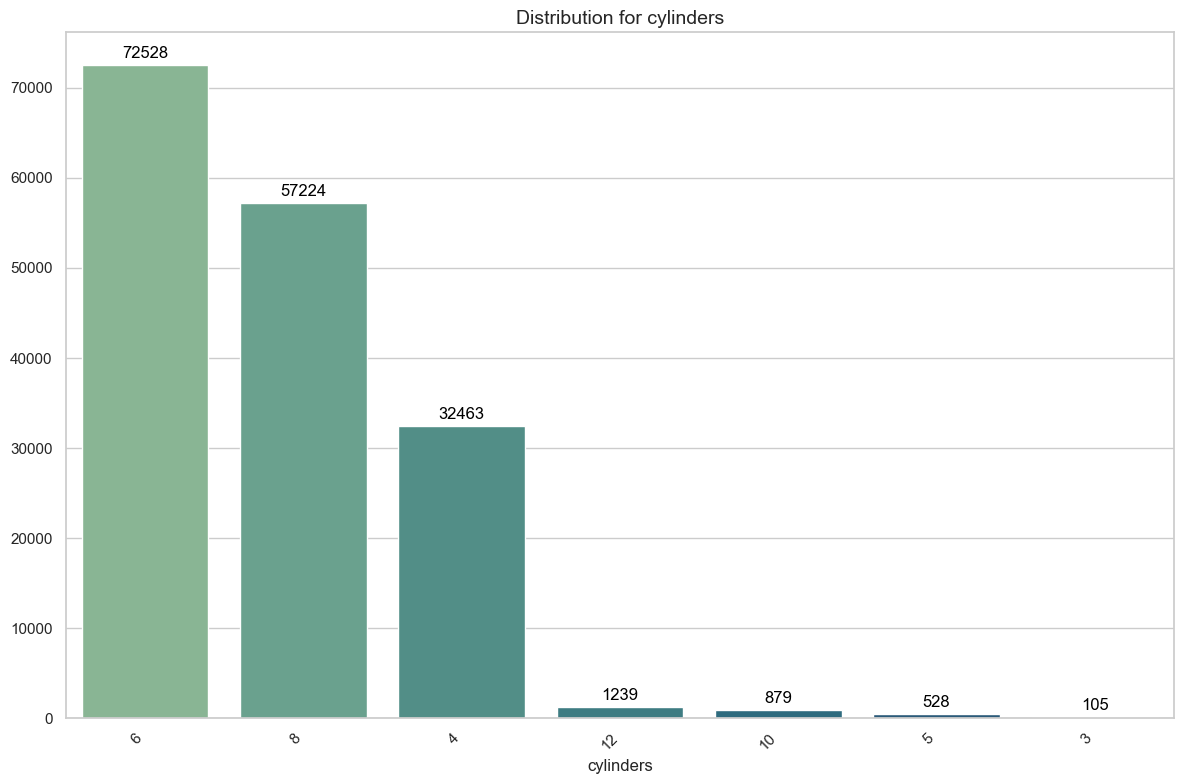

In [22]:
draw_categorical_bar_chart(train_df, 'cylinders', top_n=25)

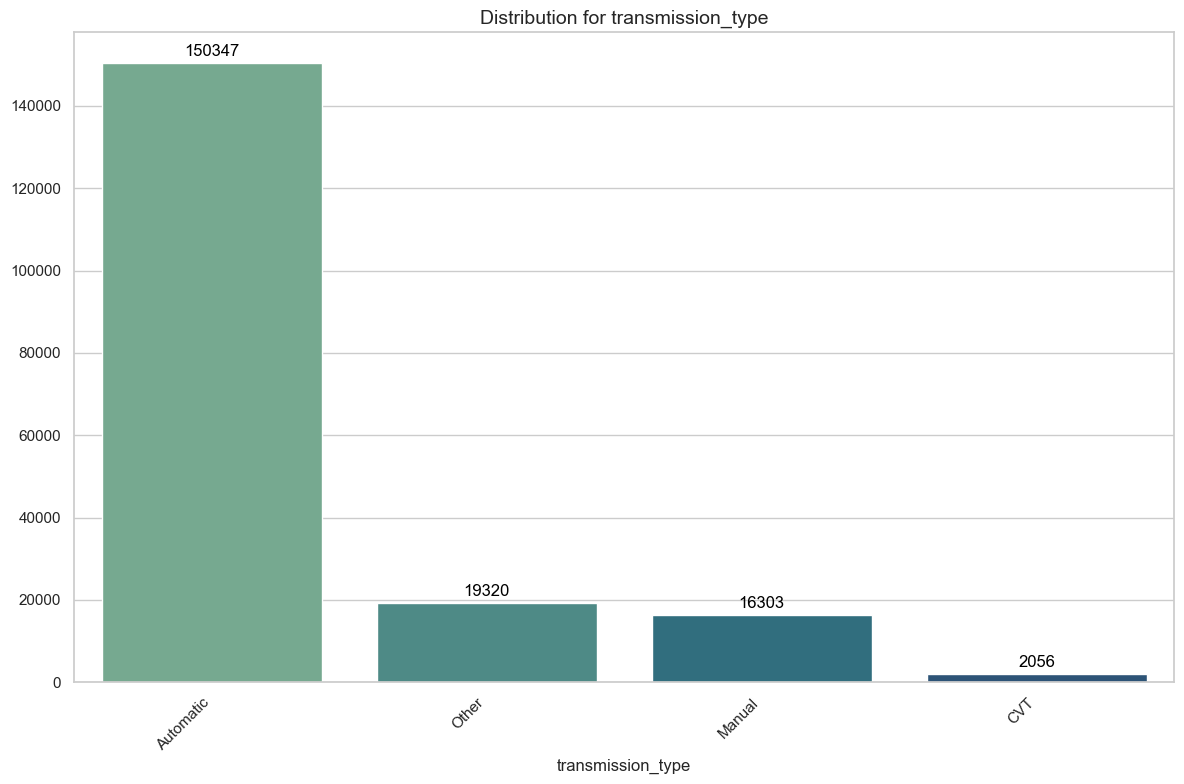

In [23]:
draw_categorical_bar_chart(train_df, 'transmission_type', top_n=25)

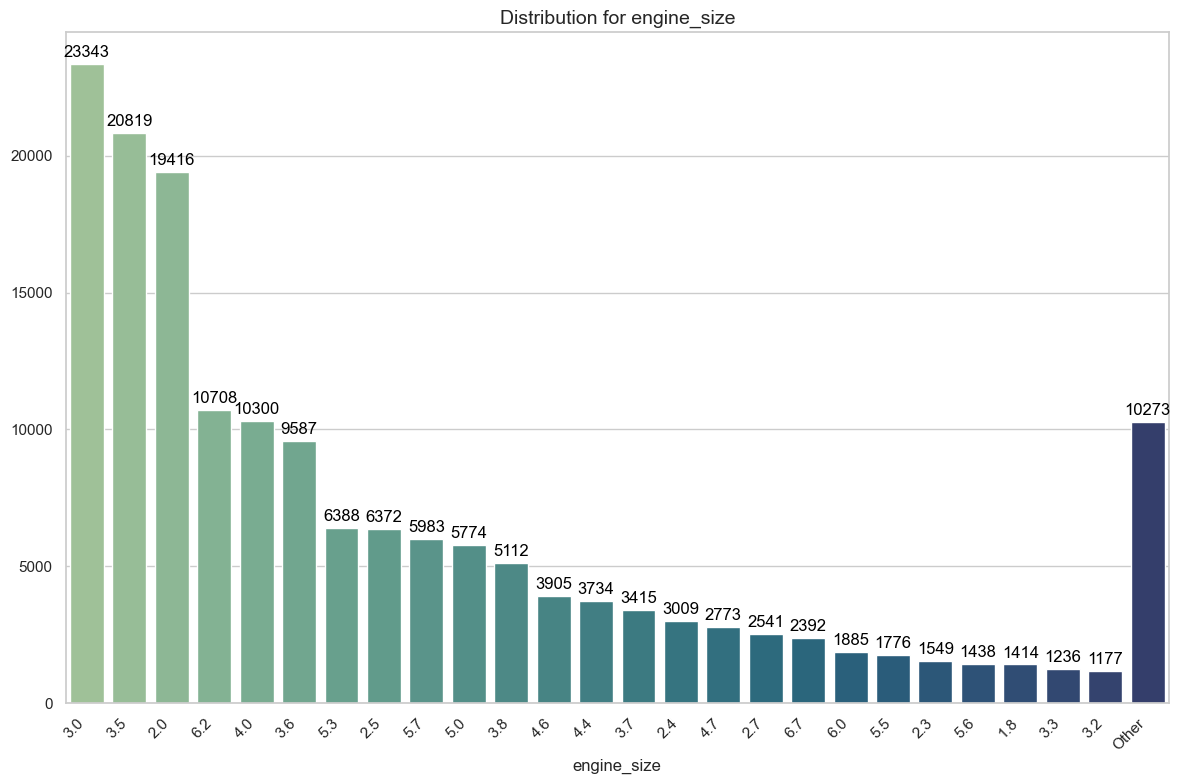

In [24]:
draw_categorical_bar_chart(train_df, 'engine_size', top_n=25)

In [25]:
categorical_features = ['brand', 'model', 'model_year', 'fuel_type', 'ext_col', 'int_col', 
                        'accident', 'clean_title', 'cylinders', 'transmission_type', 'luxurious_brands', 'top_10_brands']
numerical_features = ['milage', 'horsepower', 'engine_size', 'rank']

In [26]:
train_df[categorical_features] = train_df[categorical_features].astype('category')
train_df[numerical_features] = train_df[numerical_features].astype('float')

train_df_final = train_df[categorical_features+numerical_features]

In [27]:
train_df_final.describe().round(2).style.format(precision=2).background_gradient(cmap="Blues")

,milage,horsepower,engine_size,rank
count,188533.00,147872.00,166319.00,188533.00
mean,65705.30,344.28,3.81,40899.18
std,49798.16,112.45,1.34,23206.24
min,100.00,118.00,0.65,1.00
25%,24115.00,265.00,3.00,21838.00
50%,57785.00,333.00,3.50,40697.00
75%,95400.00,416.00,4.80,60246.00
max,405000.00,835.00,8.30,82754.00


In [28]:
train_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   brand              188533 non-null  category
 1   model              188533 non-null  category
 2   model_year         188533 non-null  category
 3   fuel_type          187257 non-null  category
 4   ext_col            188167 non-null  category
 5   int_col            184006 non-null  category
 6   accident           186081 non-null  category
 7   clean_title        167114 non-null  category
 8   cylinders          164966 non-null  category
 9   transmission_type  188026 non-null  category
 10  luxurious_brands   188533 non-null  category
 11  top_10_brands      188533 non-null  category
 12  milage             188533 non-null  float64 
 13  horsepower         147872 non-null  float64 
 14  engine_size        166319 non-null  float64 
 15  rank               188533 non-null

## Apply Feature Engineering to Testset

In [29]:
def feature_engineering(df):
    
    categorical_features = ['brand', 'model', 'model_year', 'fuel_type', 'engine',
                            'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
    # Count the number of rows with "–" in each column
    df.replace("not supported", np.nan, inplace=True)
    df.replace("–", np.nan, inplace=True)

    # Iterate over each categorical column
    for col in categorical_features:
        # # Step 1: Replace NaN values with 'Unknown'
        # df[col].fillna('Unknown', inplace=True)
        
        # Step 2: Identify rare values (those that appear less than 40 times)
        value_counts = df[col].value_counts()
        rare_labels = value_counts[value_counts < 40].index
        
        # Step 3: Replace rare values with 'Rare'
        original_count = df[col].isin(rare_labels).sum()  # Count rows with rare values
        df[col] = df[col].apply(lambda x: 'Rare' if x in rare_labels else x)
        
        # Print out how many rows were replaced with 'Rare'
        print(f"Column '{col}': {original_count} rows replaced with 'Rare'")

    # Feature extraction
    df['horsepower'] = df['engine'].apply(extract_horsepower)
    df['engine_size'] = df['engine'].apply(extract_engine_size)
    df['cylinders'] = df['engine'].apply(extract_cylinders)
    df['engine_fuel_type'] = df['engine'].apply(extract_fuel_type)


    df.engine_fuel_type.replace("Flex Fuel Capability", "E85 Flex Fuel", inplace=True)
    # Condition where fuel_type is 'Hybrid' and engine_fuel_type is 'Gasoline'
    condition = (df['fuel_type'] == 'Hybrid') & (df['engine_fuel_type'] == 'Gasoline')

    # Replace 'Hybrid' with 'Gasoline' where the condition is met
    df.loc[condition, 'fuel_type'] = 'Gasoline'

    # List of brands for which we want to replace 'Gasoline' with 'Electric'
    electric_brands = ['Tesla', 'Rivian', 'Ford', 'Porsche', 'BMW']

    # Condition where fuel_type is 'Gasoline' and engine_fuel_type is 'Electric' and the brand is in the electric_brands list
    condition = (df['fuel_type'] == 'Gasoline') & (df['engine_fuel_type'] == 'Electric') & (df['brand'].isin(electric_brands))

    # Replace 'Gasoline' with 'Electric' where the condition is met
    df.loc[condition, 'fuel_type'] = 'Electric'

    # Replace NaN values in fuel_type with the corresponding values from engine_fuel_type
    df['fuel_type'].fillna(df['engine_fuel_type'], inplace=True)

    # Apply the function to the 'transmission' column
    df['transmission_type'] = df['transmission'].apply(extract_transmission_type)

    # convert accident to binary
    df["accident"] = df["accident"].replace(
            {"None reported": 0, "At least 1 accident or damage reported": 1}
        )

    # add a new feature based on three numerical ranking
    df["rank"] = (df["milage"].astype(str)+ "_" + df["horsepower"].astype(str) + "_" + df["cylinders"].astype(str))
    df["rank"] = df["rank"].rank(method="dense")

    luxurious_brands = [
        "Bentley",
        "Maserati",
        "Lamborghini",
        "Rolls-Royce",
        "Ferrari",
        "McLaren",
        "Aston",
        "Maybach",
    ]


    Top_10_brands = [
        "Tesla",
        "Toyota",
        "BYD",
        "Ferrari",
        "Mercedes-Benz",
        "Porsche",
        "BMW",
        "Xiaomi",
        "Volkswagen",
        "Honda",
    ]

    # Add new feature to identify luxury brands
    df["luxurious_brands"] = np.where(
        df["brand"].isin(luxurious_brands), "luxury", "regular"
    )
    # Add new feature to identify top ten brands
    df["top_10_brands"] = np.where(
        df["brand"].isin(Top_10_brands), "top_10", "unranked"
    )
    return df

In [30]:
test_df = feature_engineering(test_df)

Column 'brand': 132 rows replaced with 'Rare'
Column 'model': 20083 rows replaced with 'Rare'
Column 'model_year': 15 rows replaced with 'Rare'
Column 'fuel_type': 0 rows replaced with 'Rare'
Column 'engine': 9267 rows replaced with 'Rare'
Column 'transmission': 324 rows replaced with 'Rare'
Column 'ext_col': 3638 rows replaced with 'Rare'
Column 'int_col': 1975 rows replaced with 'Rare'
Column 'accident': 0 rows replaced with 'Rare'
Column 'clean_title': 0 rows replaced with 'Rare'


In [31]:
categorical_features = ['brand', 'model', 'model_year', 'fuel_type', 'ext_col', 'int_col', 
                        'accident', 'clean_title', 'cylinders', 'transmission_type', 'luxurious_brands', 'top_10_brands']
numerical_features = ['milage', 'horsepower', 'engine_size', 'rank']

test_df[categorical_features] = test_df[categorical_features].astype('category')
test_df[numerical_features] = test_df[numerical_features].astype('float')

test_df_final = test_df[categorical_features+numerical_features]

In [32]:
train_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   brand              188533 non-null  category
 1   model              188533 non-null  category
 2   model_year         188533 non-null  category
 3   fuel_type          187257 non-null  category
 4   ext_col            188167 non-null  category
 5   int_col            184006 non-null  category
 6   accident           186081 non-null  category
 7   clean_title        167114 non-null  category
 8   cylinders          164966 non-null  category
 9   transmission_type  188026 non-null  category
 10  luxurious_brands   188533 non-null  category
 11  top_10_brands      188533 non-null  category
 12  milage             188533 non-null  float64 
 13  horsepower         147872 non-null  float64 
 14  engine_size        166319 non-null  float64 
 15  rank               188533 non-null

In [33]:
# use Jinja2 to format output fir numerical feature distribution
test_df_final.describe().round(2).style.format(precision=2).background_gradient(cmap="Blues")

,milage,horsepower,engine_size,rank
count,125690.00,95999.00,108005.00,125690.00
mean,66042.58,344.05,3.81,29951.67
std,50223.86,111.52,1.33,17082.20
min,100.00,118.00,0.65,1.00
25%,24500.00,268.00,3.00,15870.25
50%,57500.00,333.00,3.50,29798.00
75%,95798.00,416.00,4.70,44112.00
max,405000.00,835.00,8.30,60724.00


## Modeling

In [34]:
# Define features and target for training
features = categorical_features+numerical_features
target = "price"

# Shuffle the data
train_df = train_df.groupby('price').sample(frac=1, random_state= 1).reset_index(drop = True)

# Split the dataset into training and testing
X = train_df[features]
y = train_df[target]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical feature indices (LightGBM requires categorical feature indices)
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]

# Initialize and train the LightGBM Regressor
lgb_regressor = lgb.LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)

# Train the model, specifying the categorical features
lgb_regressor.fit(X_train, y_train, categorical_feature=cat_feature_indices)

# Predict and evaluate the model on the test data
y_pred_lgb = lgb_regressor.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f"LightGBM RMSE: {rmse_lgb}")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 16
[LightGBM] [Info] Start training from score 43990.109550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

## Hyperparameter Tuning

### Prepare Optuna

In [35]:
# Define features and target for training
features = categorical_features+numerical_features
target = "price"

# Shuffle the data
train_df = train_df.groupby('price').sample(frac=1, random_state= 1).reset_index(drop = True)

# Split the dataset into training and testing
X = train_df[features]
y = train_df[target]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical feature indices (LightGBM requires categorical feature indices)
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]


def objective_lgbm(trial):

    lgbm_params = {
    'n_estimators': trial.suggest_int('n_estimators', 800, 1500),
    'num_leaves': trial.suggest_int('num_leaves', 75, 200),
    'max_depth': trial.suggest_int('max_depth', 12, 30),
    'cat_smooth': trial.suggest_int('cat_smooth', 20, 120),
    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.02),
    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 0.8),
    'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-4, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 5, 70),
    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-10, 1e-3),
    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-10, 1e-2),
    'max_bin': trial.suggest_int('max_bin', 200, 1000),
    }
    

    # Fit the model
    model_lgbm = lgb.LGBMRegressor(
        **lgbm_params, random_state=42, loss_function="RMSE", verbose=-1
    )

    model_lgbm.fit(X_train, y_train, categorical_feature=cat_feature_indices)

    # Predict and calculate mean squared error score
    y_pred = model_lgbm.predict(X_test)

    return mean_squared_error(y_test, y_pred, squared = False)

### Create a study object | optimization

In [36]:
study_lgbm = optuna.create_study(
    study_name="LGBM_used_car",  
    direction="minimize"
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm.optimize(objective_lgbm, n_trials=30, show_progress_bar=True)

[I 2024-09-15 00:31:39,727] A new study created in memory with name: LGBM_used_car
Best trial: 26. Best value: 65722.6: 100%|██████████| 30/30 [02:54<00:00,  5.81s/it]


### Best Trial

In [37]:
print("Best trial:", study_lgbm.best_trial)

Best trial: FrozenTrial(number=26, state=1, values=[65722.59781371418], datetime_start=datetime.datetime(2024, 9, 15, 0, 34, 11, 746827), datetime_complete=datetime.datetime(2024, 9, 15, 0, 34, 17, 211346), params={'n_estimators': 1002, 'num_leaves': 84, 'max_depth': 21, 'cat_smooth': 111, 'learning_rate': 0.0035946268548615245, 'subsample': 0.9640722570105282, 'colsample_bytree': 0.4010636699797745, 'min_split_gain': 0.0013412411617920717, 'min_child_weight': 33, 'lambda_l2': 0.0009751759805300073, 'lambda_l1': 5.164289863769739e-06, 'max_bin': 667}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1500, log=False, low=800, step=1), 'num_leaves': IntDistribution(high=200, log=False, low=75, step=1), 'max_depth': IntDistribution(high=30, log=False, low=12, step=1), 'cat_smooth': IntDistribution(high=120, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.02, log=True, low=0.001, step=None), 'subsample': Float

### Best Parameters

In [38]:
print("Best parameters:", study_lgbm.best_params)

Best parameters: {'n_estimators': 1002, 'num_leaves': 84, 'max_depth': 21, 'cat_smooth': 111, 'learning_rate': 0.0035946268548615245, 'subsample': 0.9640722570105282, 'colsample_bytree': 0.4010636699797745, 'min_split_gain': 0.0013412411617920717, 'min_child_weight': 33, 'lambda_l2': 0.0009751759805300073, 'lambda_l1': 5.164289863769739e-06, 'max_bin': 667}


### Vidualize Optimization History

In [39]:
fig = optuna.visualization.plot_optimization_history(study_lgbm)
fig.update_layout(
    font_family="Courier New",
    font_size=12,
    title_font_family="Times New Roman",
    title_font_color="steelblue",
    legend_title_font_color="black",
    plot_bgcolor='#e9eff6',
    paper_bgcolor='#f5fbf5',
)
fig.update_xaxes(color = "darkgreen")
fig.update_traces(marker_color='green')

### Visualize Parameters Importances

In [40]:
fig = optuna.visualization.plot_param_importances(study_lgbm)
fig.update_layout(
    font_family="Courier New",
    font_size=12,
    title_font_family="Times New Roman",
    title_font_color="steelblue",
    legend_title_font_color="black",
    plot_bgcolor='#e9eff6',
    paper_bgcolor='#f5fbf5',
)
fig.update_xaxes(color = "darkgreen")
fig.update_traces(marker_color='green')

## Ensemble Methods(Will do it in another notebook to kept improving my final models)

# Eveluate and Submit

### Prepare Submittion

**LightGBM**

Best RMSE: 72239.79098

In [41]:
# Step 1: Define features and target for training
categorical_features = ['brand', 'model', 'model_year', 'fuel_type', 'ext_col', 'int_col', 
                        'accident', 'clean_title', 'cylinders', 'transmission_type', 'luxurious_brands', 'top_10_brands']
numerical_features = ['milage', 'horsepower', 'engine_size', 'rank']

target = "price"

# Step 2: Shuffle the data
train_df = train_df.groupby('price').sample(frac=1, random_state= 1).reset_index(drop = True)

# Step 3: Prepare the training data
X_train_final = train_df[categorical_features+numerical_features]
y_train_final = train_df[target]

# Step 4: Identify categorical feature indices (LightGBM can handle categorical features natively)
cat_feature_indices = [X_train_final.columns.get_loc(col) for col in categorical_features]

# Step 5: Initialize and train the LightGBM model
lgb_regressor = lgb.LGBMRegressor(**study_lgbm.best_params, importance_type="gain", verbose=-1)

# Train the model with categorical features
lgb_regressor.fit(X_train_final, y_train_final, categorical_feature=cat_feature_indices)

# Step 6: Prepare the test data for predictions
X_test_final = test_df_final

# Step 7: Make predictions on the test set
y_test_pred_lgb = lgb_regressor.predict(X_test_final)

# Step 8: Prepare the submission DataFrame
submission_df_lgb = pd.DataFrame({
    'id': test_df['id'],  # Retrieve the 'id' from test_df
    'price': y_test_pred_lgb  # Use the predicted prices
})

# Step 9: Save the submission file
# submission_df_lgb.to_csv('/Users/shudizhao/data_projects/used_car_price_prediction/lgbm_submission_v1.csv', index=False)
submission_df_lgb.to_csv(r'C:\Users\shudi\OneDrive\Desktop\Projects\Kaggle Competition\used_car_price_prediction\lgbm_submission_v4.csv', index=False)

# Check the first few rows of the submission
print(submission_df_lgb.head())

       id         price
0  188533  19984.905295
1  188534  73052.472020
2  188535  57488.735722
3  188536  41146.976138
4  188537  34399.614633


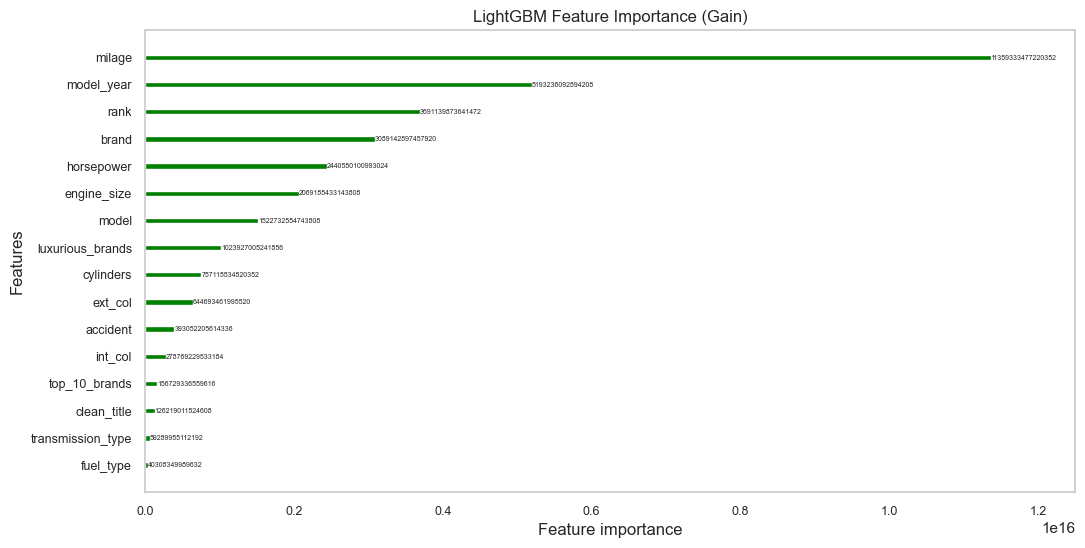

In [42]:
plt.rcParams['font.size'] = 5
lgb.plot_importance(
    lgb_regressor,
    importance_type="gain",
    figsize=(12, 6),
    precision=0,
    grid=False,
    title="LightGBM Feature Importance (Gain)",
    color = "green"
)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)